## **Boots and Cats Group:**
 **a generative classical piano music RNN**

For instructions/order to run these cells in please follow the numbering in *italics* above each cell. This is needed as some functions are used out of order of the sections they fall under.

*running order: 1*

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import pickle
from google.colab import drive

# Mount drive
drive.mount('/content/gdrive')
# UPDATE your path to the data
path_to_data = '/content/gdrive/My Drive/University/Year 4/CSC413/Project/data.pickle'

!pip install pretty_midi
# UPDATE your path to the data_parser.py, used for creating midi files from the generated sequences 
!cp "/content/gdrive/My Drive/University/Year 4/CSC413/Project/data_parser.py" .

from data_parser import create_midi_file


Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=836762ca8866839d8c3b207fffebd8411698acf25741694db4e8acdd4a7cd197
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi


# **Model**

*running order: 2*

In [9]:
class MusicGenRNN(nn.Module):
  """
  Generative classical piano music RNN.
  Please see the README.md for a description and analysis of the model.

  Note: Please define "device" variable before instantiating a model,
  as it is used in __init__().
  """

  def __init__(self, hidden_size = 512, num_rnn_layers = 1, bias_rnn = True, pitch_embedding_size = 130):
    """
    To initialize the model, define the following:

    hidden_size (int), this is the width (number of LSTM blocks) in the hidden layer/LSTM RNN layers used. 
                  These layers act as the encoding layers for the input sequence/tokens/notes.

    num_rnn_layers (int), this is the number of LSTM layers in the model. I.e. the number of 
                    encoding layers, each is of width hidden_size i.e. has hidden_size number of LSTM blocks.
    
    bias_rnn (bool), True or False for wether the LSTM RNNs should or should not have bias terms.

    pitch_embedding_size (int), dimension of embedding to use for the pitch.

    Values we used in our final model were: 
      hidden_size = 512
      num_rnn_layers = 3
      bias_rnn = True
      pitch_embedding_size = 130
    """

    super(MusicGenRNN, self).__init__()

    # pitch_vocab_size = number of pitches possible + begin sequence token
    self.pitch_vocab_size = 128 + 1

    # make index to one hot vector matrix, 
    # indentity of pitch_vocab_size x pitch_vocab_size, 
    # to turn pitch index to one hot vector
    self.ident = torch.eye(self.pitch_vocab_size).to(device)

    # number of units in LSTM RNN encoder
    self.hidden_size = hidden_size
    
    # embedding size for pitch, to turn one hots to continous embedded vectors
    self.pitch_embedding_size = pitch_embedding_size

    # embedding matrix, define as Linear layer with no bias
    self.pitch_embedding_layer = nn.Linear(self.pitch_vocab_size, self.pitch_embedding_size, bias=False)
    
    # LSTM params nn.LSTM(input_size, hidden_size, num_layers, bias, batch_first=True, dropout)
    # add two to embedding size to account for step and duration that 
    # will be concatenated to this embedded vector
    self.rnn = nn.LSTM(self.pitch_embedding_size + 2, hidden_size, num_rnn_layers, bias=bias_rnn, batch_first=True, dropout=0)
    
    # decoders to get distributions and values for pitch, step and duration
    # we went with 300 here as it is in between deafult 512 and pitch_vocab_size
    # two decoders here to allow for non-linearity between the layers
    self.decoder_pitch1 = nn.Linear(hidden_size, 300)
    self.decoder_pitch2 = nn.Linear(300, self.pitch_vocab_size)

    # step and duration decoders
    self.decoder_step = nn.Linear(hidden_size, 1)
    self.decoder_duration = nn.Linear(hidden_size, 1)


  def forward(self, input, hidden_in=None):
    """
    Return the generated output from passing in an input token and hidden_in state.

    hidden_state, this is the previous hidden state of the model. Default is None 
                  when starting from scratch.

    input, this is a Nxlx3 size tensor. N is the batch size, this should be at least 1,
          l is the sequence length again at least 1, 3 is then token/note dimension.
          At input[i, j, 0] should be the pitch index whos value should be between 0-128,
          where 0-127 (inclusive) are playable pitches, 128 is the begin sequence pitch.
          At input[i, j, 1] should be the continous value for the notes step. At input[i, j, 2] 
          should be the continous value for the notes duration.

    return a Nxlx131 tensor where output[i, j, :129] is the categorical pitch distribution,
          output[i, j, 129] is the step value, and output[i, j, 130] is the duration value
          for the predicted next note/token.
    """

    # parse input, assume batch of at least one
    pitch_in = input[:, :, 0].long()
    step_in = input[:, :, 1]
    dur_in = input[:, :, 2]

    # embed pitch
    pitch_one_hot = self.ident[pitch_in]
    pitch_emb = self.pitch_embedding_layer(pitch_one_hot)

    # concat everything back together to encode it
    inp = torch.concat((pitch_emb, step_in.unsqueeze(2), dur_in.unsqueeze(2)), dim=2)
    output, hidden_out = self.rnn(inp, hidden_in) 

    # decode everything
    out_pitch = self.decoder_pitch2(torch.relu(self.decoder_pitch1(output)))  
    out_step = self.decoder_step(output)
    out_dur = self.decoder_duration(output)

    # return concatenation of the each decoded output, and the hidden state
    return torch.concat((out_pitch, out_step, out_dur), dim=2), hidden_out

# **Loading Data**

*running order: 3*

(3603, 64, 3)
(997, 64, 3)
(1214, 64, 3)


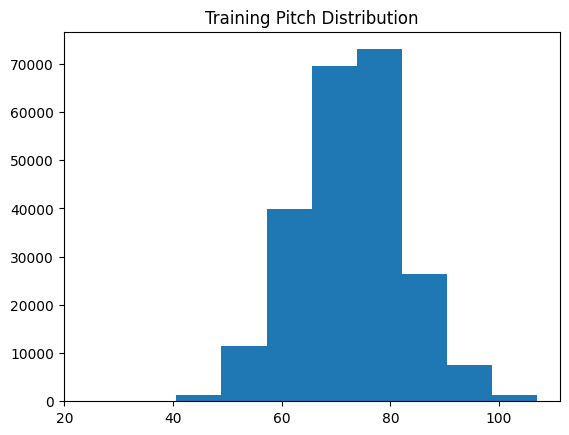

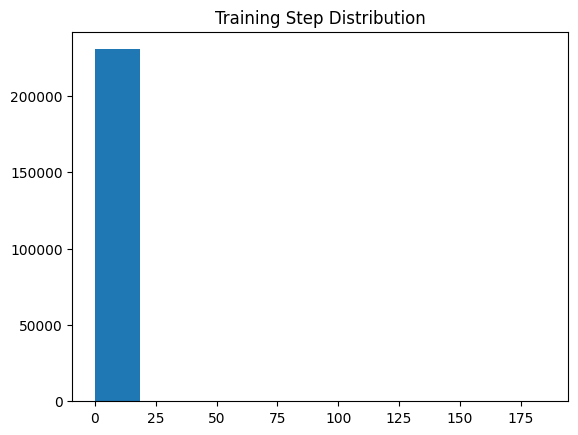

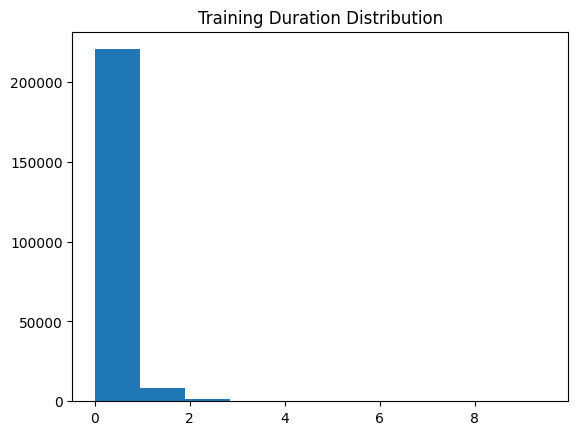

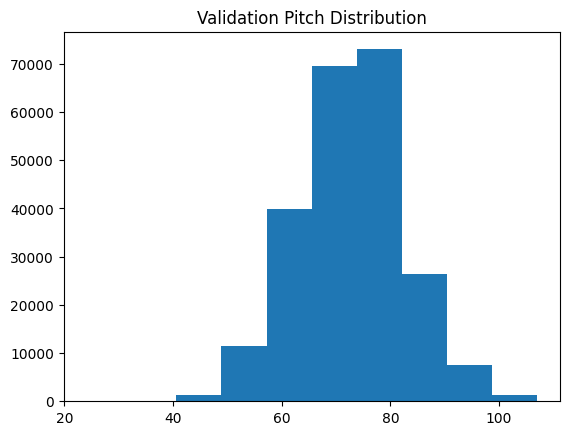

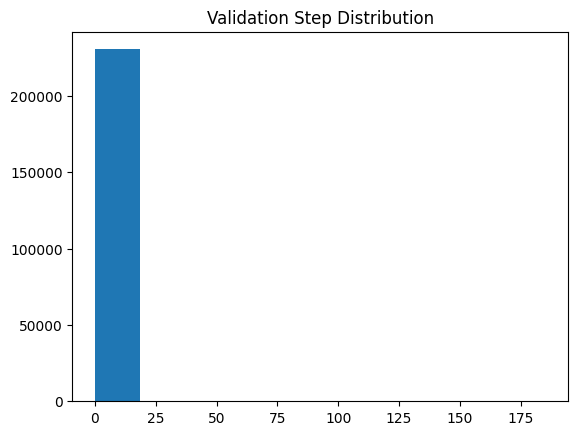

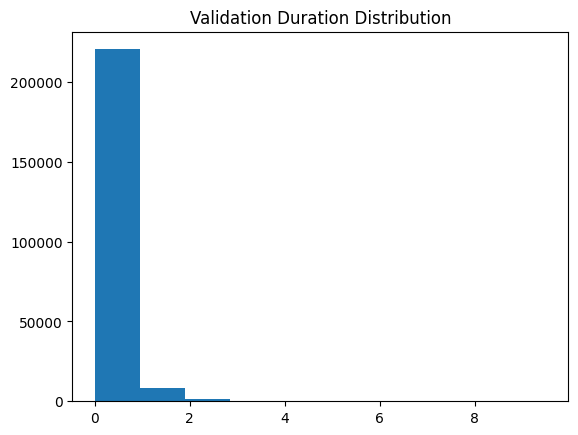

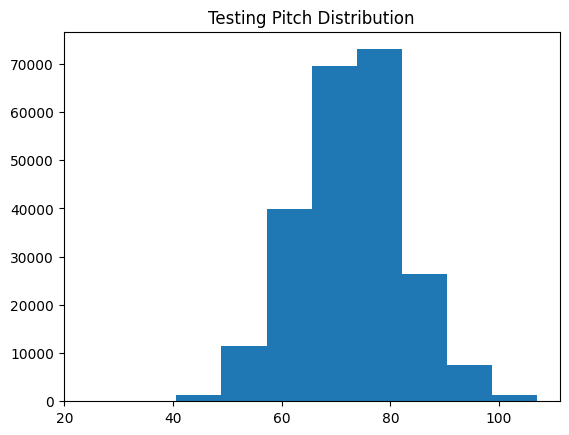

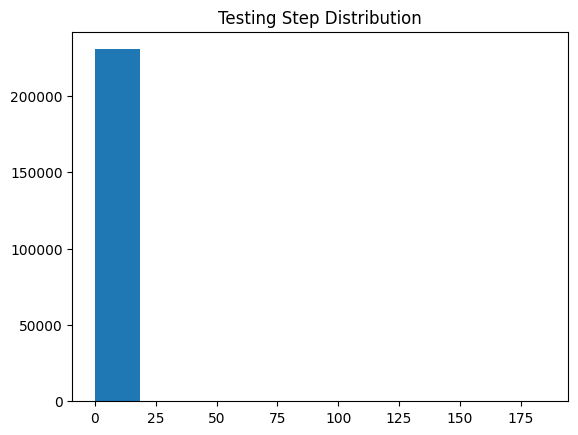

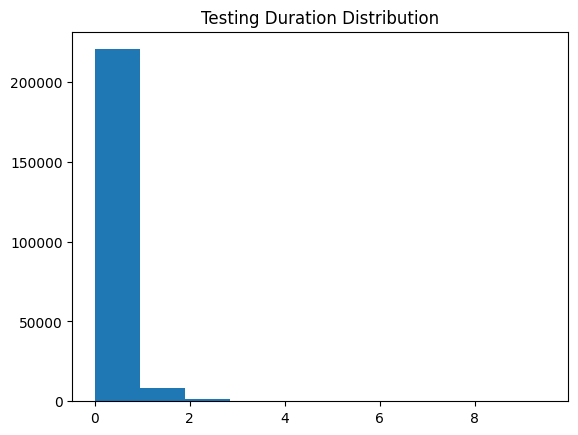

In [5]:
# load data from the path to the pickle file, path_to_data, defined in the imports
with open(path_to_data, 'rb') as f:
    dataset = pickle.load(f)

train_set, validation_set, test_set = dataset

print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

# Generate histograms of the notes for each data set.
train_pitch_histo = []
valid_pitch_histo = []
test_pitch_histo = [] 

pitch_histos = [train_pitch_histo, valid_pitch_histo, test_pitch_histo]

# discretize step and duration into bins 
train_step_histo = [] 
valid_step_histo = [] 
test_step_histo = [] 

step_histos = [train_step_histo, valid_step_histo, test_step_histo]


train_dur_histo = []
valid_dur_histo = [] 
test_dur_histo = [] 

dur_histos = [train_dur_histo, valid_dur_histo, test_dur_histo]

set_name = ["Training", "Validation", "Testing"]
all_histos = [pitch_histos, step_histos, dur_histos]
for i, data_set in enumerate([train_set, validation_set, test_set]):
  for sequence in train_set:
    for token in sequence:
      pitch, step, dur = token
      pitch_histos[i].append(int(pitch))
      step_histos[i].append(step)
      dur_histos[i].append(dur)
  for j, distro in enumerate(["Pitch", "Step", "Duration"]):
    plt.title(f"{set_name[i]} {distro} Distribution")
    plt.hist(all_histos[j][i])
    plt.show()    

# **Training**

*running order: 4*

In [4]:
# global variables used for storing the distribution of notes components [pitch, step, duration]
# for the training and validation steps. We store these global for effecient accuracy computation
train_distros = []
valid_distros = []

def train(model, device, train_data, valid_data, batch_size=32, weight_decay=0.0,
           learning_rate=0.001, num_epochs=7, checkpoint_path=None):
  """
  Train the model using gradient descent with an ADAM optimizer.

  model (MusicGenRNN), is an instance of the MusicGenRNN model above.
  device (torch.device), is the device either CPU or type of GPU to run on, aquired via torch.device()
  train_data (numpy array of shape Nxlx3), is the training data set to to train on.
  valid_data (numpy array of shape Nxlx3), is the validation data set to tune hyperparameters with.
            - Note: for the Nxlx3 shape, N is the number of samples, 
                    l is the sequence length, and the last dimension is
                    note information in order of [pitch index, step, duration]
  batch_size (int), is the batch size to use.
  wieght_decay (float), is the wieght decay value to use, to help prevent overfitting.
  learning_rate (float), is the learning rate to use, to fine tune step sizes.
  num_epochs (int), is the number of epochs to run, to train the model with the training data.
  """

  # get loss function, CE has softmax built in
  # use three losses one for each generated output component
  criterion_pitch = nn.CrossEntropyLoss()
  criterion_step = nn.MSELoss()
  criterion_dur = nn.MSELoss()

  # get optimizer
  optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)
  
  # get dataloader, load training data, and validation data
  train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
  validation_loader = torch.utils.data.DataLoader(valid_data,
                                               batch_size=batch_size,
                                               shuffle=True)
  
  # learning curve information for plotting
  train_iters_list, losses_training, iter_at_epoch, train_acc, val_acc = [], [], [], [], []
  valid_iters_list, losses_validation =  [], []
  num_iters_train, num_iters_valid = 0, 0

  # iterate the given number of epochs
  for epoch in range(num_epochs):
    # shuffling data done automatically by data loader
    for batch_of_sequences in iter(train_loader): # iterate through all data in train loader
    # batch_of_sequences is of batch size
      # account for smaller last batch
      if batch_of_sequences.size()[0] < batch_size:
        continue

      # compute forward and backward pass

      model.train() # ensure model in train mode

      # add <BOS>=128 to input sequences, pitch values range 0-127 inclusive
      BOS = torch.tensor([128, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
      input = torch.concat((BOS, batch_of_sequences), dim=1).to(device)
      # only go up to second last input as last one is just predicted never fed in
      input = input[:, :-1, :] 
      out, _ = model(input.float())
      out_pitch = out[:, :, :129]
      out_step = out[:, :, 129]
      out_dur = out[:, :, 130]

      targets = batch_of_sequences.float().to(device)
      targets_pitch = targets[:, :, 0].long()
      targets_step = targets[:, :, 1]
      targets_dur = targets[:, :, 2]
      
      # compute losses
      loss_pitch = criterion_pitch(out_pitch.reshape(-1, model.pitch_vocab_size), targets_pitch.reshape(-1).long())
      loss_step = criterion_step(out_step, targets_step)
      loss_dur = criterion_dur(out_dur, targets_dur)
      total_loss = loss_step + loss_dur + loss_pitch
      # go backward/grad descent
      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      # gather plotting data
      num_iters_train += 1
      losses_training.append(float(loss_pitch.item() + loss_step.item() + loss_dur.item()))
      train_iters_list.append(num_iters_train)

  
    # iterate through all data in valid loader
    for batch_of_sequences in iter(validation_loader): 
      # batch_of_sequences is of batch size
        # account for smaller last batch
        if batch_of_sequences.size()[0] < batch_size:
          continue
        # compute forward
        model.eval() # ensure model in eval mode, no descent here just trying to measure accuarcy

        # add <BOS>=128, pitch values range 0-127 inclusive
        BOS = torch.tensor([128, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
        input = torch.concat((BOS, batch_of_sequences), dim=1).to(device)
        # only go up to second last input as last one is just predicted never fed in
        input = input[:, :-1, :] 
        out, _ = model(input.float())
        out_pitch = out[:, :, :129]
        out_step = out[:, :, 129]
        out_dur = out[:, :, 130]

        targets = batch_of_sequences.float().to(device)
        targets_pitch = targets[:, :, 0].long()
        targets_step = targets[:, :, 1]
        targets_dur = targets[:, :, 2]
        
        # compute losses
        loss_pitch_v = criterion_pitch(out_pitch.reshape(-1, model.pitch_vocab_size), targets_pitch.reshape(-1).long())
        loss_step_v = criterion_step(out_step, targets_step)
        loss_dur_v = criterion_dur(out_dur, targets_dur)
        total_loss_v = loss_pitch_v + loss_step_v + loss_dur_v
        
        # gather plotting data
        num_iters_valid += 1
        losses_validation.append(float(loss_pitch_v.item() + loss_step_v.item() + loss_dur_v.item()))
        valid_iters_list.append(num_iters_valid)

    # --- epoch ended ---
    # check point model
    if (checkpoint_path is not None) and num_iters_train > 0:
      torch.save(model.state_dict(), checkpoint_path.format(num_iters_train))

    # track learning curve info
    iter_at_epoch.append(num_iters_train)
    cur_train_acc, cur_val_acc = estimate_accuracy(model, torch.Tensor(train_data).to(device),
                                                   torch.Tensor(valid_data).to(device), 50,
                                                   compute_set_distros=(len(iter_at_epoch) == 1))
    train_acc.append(np.array(cur_train_acc) * 100)
    val_acc.append(np.array(cur_val_acc) * 100)

    # the lower accuracy %'s the better, kind of counter intuitive, but this is how our accuracy measure works
    print("""Epoch %d. Iter %d.  [Train Acc pitch %.0f%%, step %.0f%%, duration %.0f%%, Train Loss %f] """ \
                              """[Valid Acc %.0f%%, step %.0f%%, duration %.0f%%, Valid Loss %f]""" %
              (epoch, iter_at_epoch[-1], train_acc[-1][0], train_acc[-1][1], train_acc[-1][2],
               float((loss_pitch + loss_step + loss_dur).cpu().detach().numpy()),
               val_acc[-1][0], val_acc[-1][1], val_acc[-1][2],
               float((loss_pitch_v + loss_step_v + loss_dur_v).cpu().detach().numpy())))
    
  return train_iters_list, losses_training, valid_iters_list, losses_validation, iter_at_epoch, np.array(train_acc), np.array(val_acc)


def plot_learning_curve(train_iters_list, losses_training, valid_iters_list, losses_validation, iter_at_epoch, train_acc, val_acc):
    """
    Plot the learning curves, all accuracy plots, and losses.
    """
    plt.title("Learning Curve: Train Loss per Iteration")
    plt.plot(train_iters_list, losses_training, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    plt.title("Learning Curve: Valid Loss per Iteration")
    plt.plot(valid_iters_list, losses_validation, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    plt.title("Learning Curve: Accuracy Pitch per Iteration")
    plt.plot(iter_at_epoch, train_acc[:, 0], label="Train")
    plt.plot(iter_at_epoch, val_acc[:, 0], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve: Accuracy Step per Iteration")
    plt.plot(iter_at_epoch, train_acc[:, 1], label="Train")
    plt.plot(iter_at_epoch, val_acc[:, 1], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve: Accuracy Duration per Iteration")
    plt.plot(iter_at_epoch, train_acc[:, 2], label="Train")
    plt.plot(iter_at_epoch, val_acc[:, 2], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


def estimate_accuracy(model, train_set, valid_set, num_samples, compute_set_distros):
  """
  Given the model, training set and validation set and number of samples to 
  generate to comupte a model distibution with, compute the accuracy of the 
  model on the two given set.

  - Note: this uses the sample_sequence() function so please make sure its cell is 
    run prior to calling this.

  model (MusicGenRNN), is an instance of MusicGenRNN model defined above.
  train_set, valid_set (Tensors of shape Nxlx3), the datasets to compare the
                                     models generated note distribution with.
                      - Note: these datasets can be any including the test_set,
                       however the inputs are named this way for training purposes.
  num_samples (int), the number of samples to be generated from the model to be 
                      used to produce a distribution of note components from.
  compute_set_distros (bool), if true generate the distributions of the datasets 
                      and store them in globals train_distros, and valid_distros
                      to avoid computing them again for effeciency.

  return a list of length two containing two length three sublists. The first
        sublist is the [pitch, step, duration] JSD values between the model 
        note distrubtion of each component of sampled notes and 
        the training set, and the second sublist is the samething but with the 
        validation set.
  """

  # build histogram/distribtution of tokens over train and valid set
  global train_distros
  global valid_distros

  if compute_set_distros:
    train_pitch_histo = [0.0001] * 128
    valid_pitch_histo = [0.0001] * 128

    # discretize step and duration into bins 
    train_step_histo = [0.0001] * int((15 - 0) // 0.5)
    valid_step_histo = [0.0001] * int((15 - 0) // 0.5)

    train_dur_histo = [0.0001] * int((15 - 0) // 0.5)
    valid_dur_histo = [0.0001] * int((15 - 0) // 0.5)

    for sequence in train_set:
      for token in sequence:
        pitch, step, dur = token
        train_pitch_histo[int(pitch)] += 1
        # use min here to make sure long step or duration well over 15 ends up in upper bin
        # use "step // 0.5 if step > 0 else 0" to ensure steps/dur < 0 end up in lowest bin
        train_step_histo[min(int(step // 0.5 if step > 0 else 0), len(train_step_histo) - 1)] += 1
        train_dur_histo[min(int(dur // 0.5 if step > 0 else 0), len(train_dur_histo) - 1)] += 1

    for sequence in valid_set:
      for token in sequence:
        pitch, step, dur = token
        valid_pitch_histo[int(pitch)] += 1
        valid_step_histo[min(int(step // 0.5 if step > 0 else 0), len(valid_step_histo) - 1)] += 1
        valid_dur_histo[min(int(dur // 0.5 if step > 0 else 0), len(valid_dur_histo) - 1)] += 1

    # set globals so we don't need to compute this more then once
    train_distros = [train_pitch_histo, train_step_histo, train_dur_histo] 
    valid_distros = [valid_pitch_histo, valid_step_histo, valid_dur_histo]
    
  else:
    train_pitch_histo, train_step_histo, train_dur_histo = train_distros
    valid_pitch_histo, valid_step_histo, valid_dur_histo = valid_distros

  model_pitch_histo = [0.0001] * 128
  model_step_histo = [0.0001] * int((15 - 0) // 0.5)
  model_dur_histo = [0.0001] * int((15 - 0) // 0.5)

  for _ in range(num_samples):
    gen_seq = sample_sequence(model, max_len=100, temperature=0.8)
    for token in gen_seq:
      pitch, step, dur = token
      model_pitch_histo[min(max(int(pitch), 0), len(model_pitch_histo) - 1)] += 1
      model_step_histo[min(int(step // 0.5 if step > 0 else 0), len(model_step_histo) - 1)] += 1
      model_dur_histo[min(int(dur // 0.5 if step > 0 else 0), len(model_dur_histo) - 1)] += 1
  
  # compute distro similarity using JSD as it is symmetric and bounded between 0 and 1
  # https://medium.com/geekculture/techniques-to-measure-probability-distribution-similarity-9145678d68a6

  return [[_jensen_shannon_divergence(model_pitch_histo, train_pitch_histo),
           _jensen_shannon_divergence(model_step_histo, train_step_histo),
           _jensen_shannon_divergence(model_dur_histo, train_dur_histo)],
           [_jensen_shannon_divergence(model_pitch_histo, valid_pitch_histo),
            _jensen_shannon_divergence(model_step_histo, valid_step_histo),
            _jensen_shannon_divergence(model_dur_histo, valid_dur_histo)]]


def _kullback_leibler_divergence(p_probs, q_probs):  
  """
  Compute the KL divergence of the two distributions.

  p_probs, and q_probs (numpy arrays) are two probability distributions represented
  as numpy arrays.
  """

  kl_div = p_probs * (np.log(p_probs / q_probs) / np.log(2))
  return np.sum(kl_div)


def _jensen_shannon_divergence(distro_model, distro_set):
  """
  Compute the JSD of the two distributions.

  distro_model, and distro_set (numpy arrays) are two probability distributions represented
  as numpy arrays.
  """

  # make numpy arrays
  distro_model = np.array(distro_model)
  distro_set = np.array(distro_set)
  # normalize both distros
  distro_model = distro_model / distro_model.sum()
  distro_set = distro_set / distro_set.sum()
  # average them
  avg_distro = (distro_model + distro_set) / 2
  # return avg of KL(model_distro, avg) and KL(<valid/train>_distro, avg)
  return (_kullback_leibler_divergence(distro_model, avg_distro) 
              + _kullback_leibler_divergence(distro_set, avg_distro)) / 2


*running order: 6 if training the model from scratch*

Epoch 0. Iter 2.  [Train Acc pitch 45%, step 0%, duration 3%, Train Loss 5.011658] [Valid Acc 48%, step 0%, duration 3%, Valid Loss 5.345420]
Epoch 1. Iter 4.  [Train Acc pitch 42%, step 0%, duration 3%, Train Loss 4.941677] [Valid Acc 45%, step 0%, duration 3%, Valid Loss 4.962184]
Epoch 2. Iter 6.  [Train Acc pitch 39%, step 0%, duration 3%, Train Loss 4.902458] [Valid Acc 43%, step 0%, duration 3%, Valid Loss 4.927321]
Epoch 3. Iter 8.  [Train Acc pitch 21%, step 0%, duration 61%, Train Loss 4.765785] [Valid Acc 26%, step 0%, duration 61%, Valid Loss 5.069103]
Epoch 4. Iter 10.  [Train Acc pitch 15%, step 0%, duration 3%, Train Loss 4.508241] [Valid Acc 20%, step 0%, duration 3%, Valid Loss 4.364552]
Epoch 5. Iter 12.  [Train Acc pitch 8%, step 0%, duration 3%, Train Loss 4.128877] [Valid Acc 11%, step 0%, duration 3%, Valid Loss 4.570224]
Epoch 6. Iter 14.  [Train Acc pitch 6%, step 0%, duration 3%, Train Loss 4.163195] [Valid Acc 9%, step 0%, duration 3%, Valid Loss 4.145863]
Epoc

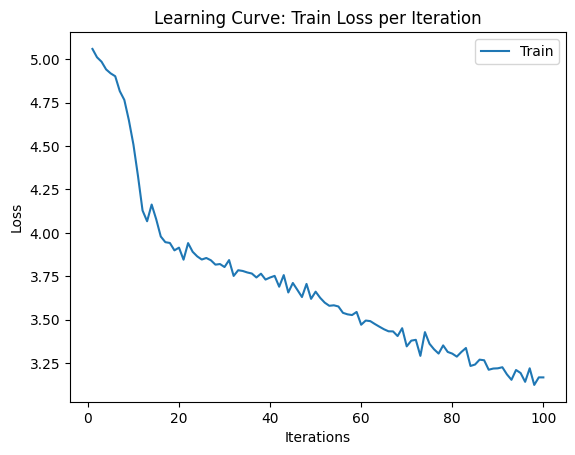

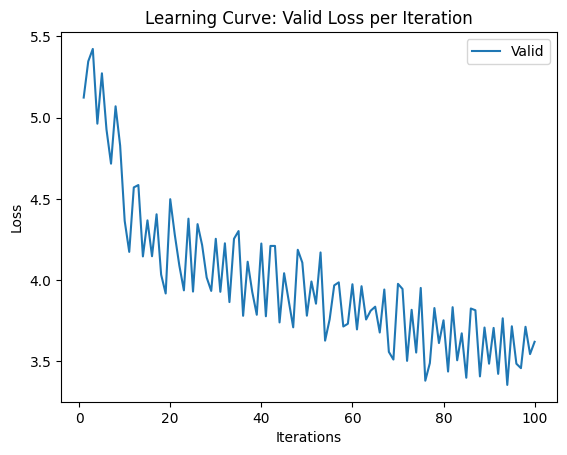

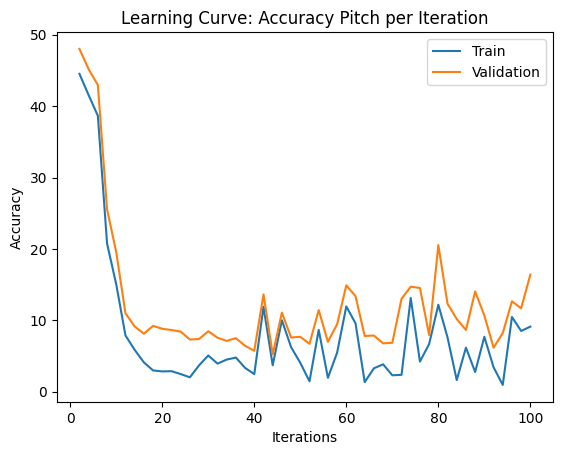

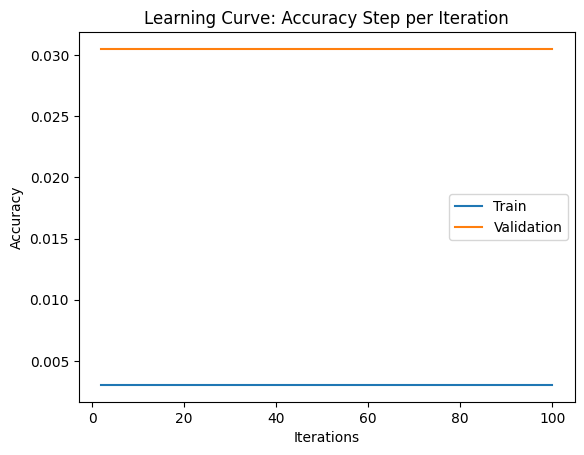

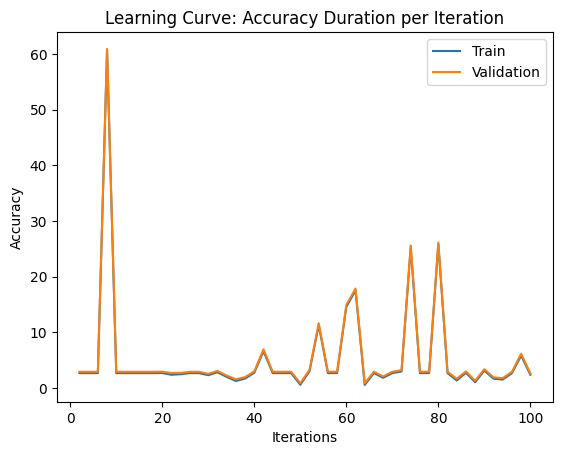

In [ ]:
# these are the values we used to train the final model with, below is the final models training output
# Everything is set to run with deivce to please ensure this variable is defined as follows before calling any function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MusicGenRNN(num_rnn_layers=3)
model.to(device)
plot_data = train(model, device, train_set[:256], validation_set[:256], num_epochs=50, batch_size=128)
plot_learning_curve(*plot_data)
# the lower accuracy %'s the better, kind of counter intuitive, but this is how our accuracy measure works

*running order: 6 If loading weights else ignore this*

In [11]:
# Everything is set to run with deivce to please ensure this variable is defined as follows before calling any function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MusicGenRNN(num_rnn_layers=3)
model.to(device)
# UPDATE
weights = torch.load("/content/gdrive/My Drive/University/Year 4/CSC413/Project/report-weights.pk", map_location=torch.device('cpu'))
model.load_state_dict(weights)
for p in model.parameters():
  print(p.shape)
# model.load_state_dict(torch.load("/content/gdrive/My Drive/University/Year 4/CSC413/Project/{}.pk".format(NAME HERE)))

torch.Size([130, 129])
torch.Size([2048, 132])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([300, 512])
torch.Size([300])
torch.Size([129, 300])
torch.Size([129])
torch.Size([1, 512])
torch.Size([1])
torch.Size([1, 512])
torch.Size([1])


In [ ]:
# UPDATE this path if you plan to save the model weights.
torch.save(model.state_dict(), "/content/gdrive/My Drive/University/Year 4/CSC413/Project/{}.pk".format("report-weights"))

# **Sampling/Producing Music**

*running order: 5*

In [5]:
def sample_sequence(model, input_seq = None, max_len = 100, temperature = 0.8):
  """
  Generate a classical piano music sequence music. Generate the sequence either 
  from an initial input sequence, input_seq, for the model to use as inspiration or from scratch.
  The sequence generated will be of length max_len. 

  model (MusicGenRNN), the model to use to compute the sequence.
  input_seq (tensor of shape lx3), l is the length of the input sequence, 3 is the number
                                  number of components to each note, i.e. [pitch, step, duration].
  max_len (int), the length of the sequence to generate. Recommended valuee given the 
                  training data shape is between 20-200.
  temperatrue (float), the randomness to push the model to sample other notes rather then
                      the most common one each time. Encourages uniqueness of output.

  Return a tensor of shape max_len x 3 where we have max_len notes made of [pitch, step, and duration].
          This is the form that data_parsers.py create_midi_file() function needs to produce output.
          If given input in input_seq, this sequence is prepended to the generate sequence.
  """

  model.eval() # ensure we are in eval mode.
  inp = torch.Tensor([[128, 0, 0]]).reshape(1, 3).float().to(device)
  # store the generated sequence
  generated_sequence = []
  hidden = None
  # if we have input to start from, feed it in
  if input_seq is not None:
    out, hidden = model(input_seq.unsqueeze(0), hidden)
  
  # in either case begin generating with the current hidden state
  for p in range(max_len):
    output, hidden = model(inp.unsqueeze(0), hidden)

    # Sample pitch from the network as a multinomial distribution
    output_dist = output[0, 0, :129].data.view(-1).div(temperature).exp()
    top_i = int(torch.multinomial(output_dist, 1)[0])

    # Add predicted values to generated sequence array
    predicted_note = [top_i, output[0, 0, 129], output[0, 0, 130]]
    generated_sequence.append(predicted_note)

    # update next input
    inp = torch.Tensor([[top_i, output[0, 0, 129], output[0, 0, 130]]]).reshape(1, 3).float().to(device)

  if input_seq is not None:
    return torch.concat((input_seq.cpu(), torch.tensor(generated_sequence).cpu()), dim=0)
    
  return torch.tensor(generated_sequence)


*running order: 7*

In [33]:
# run this to generate music files

# step 1 pick a sample Tensor to feed the model, either from a data set or
# that is user made using the data_parser.py
inp = torch.Tensor(test_set[98]).to(device)
# step 2 feed it into the model, choose you output length and tempearture, 
# described in the functions doc-string. Note if fed input
# the output will have this prepended to the generated seqeunce
gen_seq = sample_sequence(model, max_len=40, temperature=1, input_seq=inp)

# step 3 create the midi file using the below function supply the path and generated sequence
# UPDATE both paths to where to save music files too
create_midi_file("/content/gdrive/My Drive/University/Year 4/CSC413/Project/currbh-temp10-test-98-short.mid", gen_seq)
# this will be a copy of the input sequence, so you can compare the to the eextended version
create_midi_file("/content/gdrive/My Drive/University/Year 4/CSC413/Project/test.mid", inp)

# **Result Computations**

*running order: 8* If you are running results

In [13]:
def compute_results(model, train_set, validation_set, test_set):
  """
  Given the model and data sets compute the final results on each set.
  Computes the average loss, and accuracy measured using JSD of each note component,
  pitch, step and duration distributions on each of the data sets.

  model (MusicGenRNN), is an instance of MusicGenRNN model defined above.
  train_set, valid_set, test_set (numpy arrays of shape Nxlx3), the datasets
                         to compare the models generated note distribution from.
  - Note: for the Nxlx3 shape, N is the number of samples, 
          l is the sequence length, and the last dimension is
          note information in order of [pitch index, step, duration]
  """

  # compute accuracies for train, test, validation
  train_set_accs, valid_set_accs = estimate_accuracy(model, torch.Tensor(train_set).to(device),
                                                   torch.Tensor(validation_set).to(device), 50, 1)
  train_set_accs, test_set_accs = estimate_accuracy(model, torch.Tensor(train_set).to(device),
                                                   torch.Tensor(test_set).to(device), 50, 1)

  # compute average losses 
  criterion_pitch = nn.CrossEntropyLoss()
  criterion_step = nn.MSELoss()
  criterion_dur = nn.MSELoss()

  avg_losses = []
  for data_set in [train_set, validation_set, test_set]:
    set_loss = []
    for sequence in iter(data_set): 
      sequence = torch.Tensor(sequence).unsqueeze(0)
      # batch_of_sequences is of batch size
      # account for smaller last batch
      if sequence.size()[0] < 1:
        continue
      # compute forward and backward pass
      model.eval() # ensure model in eval mode, no decent here just trying to gain accuarcy

      # add <BOS>=128, pitch values range 0-127 inclusive
      BOS = torch.tensor([128, 0.0, 0.0] * 1).reshape(1, 1, 3)
      input = torch.concat((BOS, sequence), dim=1).to(device)
      # only go up to second last input as last one is just predicted never fed in
      input = input[:, :-1, :] 
      out, _ = model(input.float())
      out_pitch = out[:, :, :129]
      out_step = out[:, :, 129]
      out_dur = out[:, :, 130]

      targets = sequence.float().to(device)
      targets_pitch = targets[:, :, 0].long()
      targets_step = targets[:, :, 1]
      targets_dur = targets[:, :, 2]
      
      # compute losses
      loss_pitch = criterion_pitch(out_pitch.reshape(-1, model.pitch_vocab_size), targets_pitch.reshape(-1).long())
      loss_step = criterion_step(out_step, targets_step)
      loss_dur = criterion_dur(out_dur, targets_dur)
      total_loss = loss_pitch.item() + loss_step.item() + loss_dur.item()
      set_loss.append(total_loss)
    avg_losses.append(sum(set_loss) / data_set.shape[0])
  
 
  print(f"Training set pitch accuracy/JSD value = {train_set_accs[0]}")
  print(f"Training set step accuracy/JSD value = {train_set_accs[1]}")
  print(f"Training set duration accuracy/JSD value = {train_set_accs[2]}")

  print(f"Validation set pitch accuracy/JSD value = {valid_set_accs[0]}")
  print(f"Validation set step accuracy/JSD value = {valid_set_accs[1]}")
  print(f"Validation set duration accuracy/JSD value = {valid_set_accs[2]}")

  print(f"Test set pitch accuracy/JSD value = {test_set_accs[0]}")
  print(f"Test set step accuracy/JSD value = {test_set_accs[1]}")
  print(f"Test set duration accuracy/JSD value = {test_set_accs[2]}")

  print(f"Average training set loss = {avg_losses[0]}")
  print(f"Average validation set loss = {avg_losses[1]}")
  print(f"Average testing set loss = {avg_losses[2]}")


compute_results(model, train_set, validation_set, test_set)


Training set pitch accuracy/JSD value = 0.12274975090742343
Training set step accuracy/JSD value = 0.03802543272082731
Training set duration accuracy/JSD value = 0.03296698056417996
Validation set pitch accuracy/JSD value = 0.1352644083608216
Validation set step accuracy/JSD value = 0.033256257058337096
Validation set duration accuracy/JSD value = 0.019707985584919215
Test set pitch accuracy/JSD value = 0.13900275341415294
Test set step accuracy/JSD value = 0.04077893880128644
Test set duration accuracy/JSD value = 0.036794210566783475
Average training set loss = 3.766218465153977
Average validation set loss = 3.4298499607564668
Average testing set loss = 3.5306541454563356
